In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, GlobalMaxPooling2D,  GlobalAveragePooling2D, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, roc_auc_score
import time
import datetime
import numpy as np
import pandas as pd
import efficientnet.keras as efn

In [2]:
# установка параметров нейросети
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 20
NUM_CLASSES = 101
EPOCHS = 10 
LEARNING_RATE = 0.001
optimizer = SGD(lr = LEARNING_RATE, momentum = 0.9, nesterov = False)

In [3]:
# load dataset
tfds.disable_progress_bar()
(train_ds, test_ds, valid_ds), df_info = tfds.load(
    'food101', 
    data_dir='D:\DF',
    as_supervised=True,
    with_info=True,
    split= ['train', 'validation[:50%]', 'validation[50%:]']
)

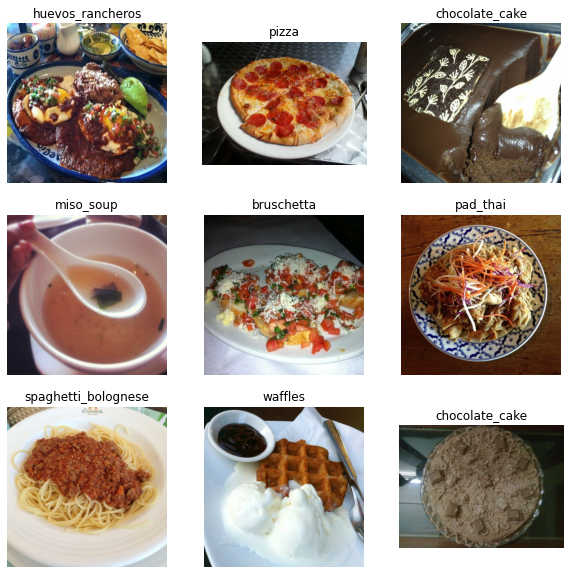

In [4]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[0]


label_info = df_info.features["label"]
fig, ax = plt.subplots(sharex=True, figsize=(10,10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

In [5]:
def _prepare(img, label):
    img = tf.cast(img, tf.float32)/255.    
    return tf.image.resize(img, INPUT_SHAPE[:2]), tf.one_hot(label, NUM_CLASSES, dtype=tf.float32)


train_ds = train_ds.shuffle(buffer_size=1000).map(_prepare).batch(BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.map(_prepare).batch(BATCH_SIZE, drop_remainder=True)
valid_ds = valid_ds.map(_prepare).batch(BATCH_SIZE, drop_remainder=True)

In [6]:
MNV2_model = MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet',
)
MNV2_model.trainable = True # Fine-tuning весов предобученной модели
# base_model.trainable = False # Заморозка весов предобученной модели

MobileNetV2_model = Sequential([
    MNV2_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax'),
])

In [7]:
MobileNetV2_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
EffNet = efn.EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
# for layer in EffNet.layers:
#     layer.trainable = False
x = EffNet.output
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
EffNet_model = Model(inputs=EffNet.input, outputs=predictions)

In [9]:
EffNet_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
base_model_resnet = ResNet50(include_top = False, weights = 'imagenet', classes = NUM_CLASSES, input_shape = INPUT_SHAPE)
# Add layers to the ResNet50
resnet_model=Sequential()
resnet_model.add(base_model_resnet)
resnet_model.add(Flatten())
resnet_model.add(Dense(1024, activation=('relu'),input_dim=512))
resnet_model.add(Dense(512, activation=('relu'))) 
resnet_model.add(Dropout(0.4))
resnet_model.add(Dense(256, activation=('relu'))) 
resnet_model.add(Dropout(0.3))
resnet_model.add(Dense(128, activation=('relu')))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(NUM_CLASSES, activation=('softmax')))

resnet_model.compile(optimizer=optimizer, 
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [11]:
models={
    'EfficientNet': EffNet_model,
    'MobileNetV2': MobileNetV2_model,    
    'ResNet50': resnet_model
}

In [12]:
class score_model_dev():
    """
    Class builds container with predictive models based
    
    Parameters
    ----------
    
    train: tf.data.Datasets
        Тренировочный, предобработатнный датасет
    valid: tf.data.Datasets
        Валидационный, предобработатнный датасет
    test: tf.data.Datasets
        Тестовый, предобработатнный датасет
    epochs: int
        число эпох
    models: dict
        словарь с можелями {'имя': модель}
    
    
    """
    def __init__(self,
                 train= None, 
                 valid= None,
                 test= None,
                 epochs: int= 1, 
                 models: dict={}):

        # Vertion of model
        self.version = '1'

        self.train = train
        self.valid = valid
        self.test = test
        self.epochs = epochs
        self.models = []

        for model in models.keys():
            self.models.append({'model_name':model,
                                'model_class':models[model],
                                'score': {'Accuracy': None},
                                'time_fit': None,
                                'time_predict': None,
                                'history': None,
                               })

    # Models training
    def fit(self):
        
        """
        Обучение моделей
   
        """
        
        assert self.train, 'Not train sample'
        
        now_str = lambda : datetime.datetime.now().strftime("%H:%M:%S")     
        for model in self.models:
            
            now_str = lambda : datetime.datetime.now().strftime("%H:%M:%S")  
            print(f"Запуск обучение модели {model['model_name']}", now_str())

            tensorboard_callback = TensorBoard(
                                log_dir='logs/' + model['model_name'], 
                                write_graph=False, update_freq=100, profile_batch=0)
            
            start_time = time.time()
            
            model['history'] = model['model_class'].fit(self.train,
                                                        epochs=self.epochs,
                                                        validation_data=self.valid,
                                                        callbacks=[tensorboard_callback]
                                                       )
            model['time_fit'] = time.time() - start_time
            
        
        # Cleaning memory
        self.train = None
        self.valid = None
        

    
    def predict(self)-> dict:
        """
        Predict result
        """
        
        assert self.test, 'Not test sample'
        
        numpy_labels = []
        for images, labels in self.test.unbatch().take(-1):  
            numpy_labels.append(labels.numpy())
            
        y_true=np.argmax(numpy_labels,axis=1)
        
        for model in self.models:            
            
            
            start_time = time.time()
            
            y_pred = model['model_class'].predict(self.test)
            
            model['time_predict'] = time.time() - start_time
        
            model['score']['One-vs-Rest ROC AUC'] = roc_auc_score(y_true, y_pred, 
                                                                  multi_class="ovr", average="weighted")
            
            model['score']['Gini'] = model['score']['One-vs-Rest ROC AUC']*2-1
            
            y_pred_class = np.argmax(y_pred, axis=-1)            
            model['score']['Accuracy'] = accuracy_score(y_true, y_pred_class)
            
            
        return self.models

            
    def showing_learning_history(self):
        """
        Визувлизация истории обучения
        """
        
        for model in self.models:     
    
            #Plotting the training and validation loss        
            fig, axs = plt.subplots(1, 2, figsize=(14, 3))
            #Training loss and validation loss
            axs[0].plot(model['history'].history['loss'],color='b',label='Training Loss')
            axs[0].plot(model['history'].history['val_loss'],color='r',label='Validation Loss')
            axs[0].legend(['Training Loss', 'Validation Loss'])
            axs[0].set_title( f'Loss on {model["model_name"]}')
            #Training accuracy and validation accuracy
            axs[1].plot(model['history'].history['accuracy'],color='b',label='Training  Accuracy')
            axs[1].plot(model['history'].history['val_accuracy'],color='r',label='Validation Accuracy')
            axs[1].legend(['Training  Accuracy', 'Validation Accuracy'])
            axs[1].set_title(f'Accuracy on {model["model_name"]}')
    
    def get_result(self)-> pd.DataFrame:
        """
        Обобщаяет данные по моделяем
        """
        name_model = []
        accuracy = []
        roc_auc = []
        gini = []
        time_fit = []
        time_predict = []
        for model in self.models:
            name_model.append(model['model_name'])
            accuracy.append(model['score']['Accuracy'])
            roc_auc.append(model['score']['One-vs-Rest ROC AUC'])
            gini.append(model['score']['Gini'])
            time_fit.append(model['time_fit'])
            time_predict.append(model['time_predict'])
            
        data = {'accuracy': accuracy, 
                'gini': gini, 
                'roc_auc': roc_auc,
                'time_fit': time_fit, 
                'time_predict': time_predict
               }
        data = pd.DataFrame.from_dict(data, orient='index', columns=name_model).T
        return data

In [13]:
smd = score_model_dev(train=train_ds, valid=valid_ds, test=test_ds, models=models, epochs=EPOCHS)

In [14]:
smd.fit()

Запуск обучение модели EfficientNet 00:51:15
Epoch 1/10
3787/3787 [==============================] - ETA: 0s - loss: 2.5769 - accuracy: 0.4007WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0070s vs `on_test_batch_end` time: 0.0270s). Check your callbacks.


3787/3787 [==============================] - 651s 172ms/step - loss: 2.5769 - accuracy: 0.4007 - val_loss: 1.0440 - val_accuracy: 0.7239
Epoch 2/10
3787/3787 [==============================] - 647s 171ms/step - loss: 1.5044 - accuracy: 0.6145 - val_loss: 0.8307 - val_accuracy: 0.7754
Epoch 3/10
3787/3787 [==============================] - 646s 171ms/step - loss: 1.2242 - accuracy: 0.6807 - val_loss: 0.7653 - val_accuracy: 0.7895
Epoch 4/10
3787/3787 [==============================] - 643s 170ms/step - loss: 1.0559 - accuracy: 0.7189 - val_loss: 0.6809 - val_accuracy: 0.8132
Epoch 5/10
3787/3787 [==============================] - 646s 171ms/step - loss: 0.9320 - accuracy: 0.7493 - val_loss: 0.6596 - val_accuracy: 0.8189
Epoch 6/10
3787/3787 [==============================] - 645s 170ms/step - loss: 0.8277 - accuracy: 0.7760 - val_loss: 0.6540 - val_accuracy: 0.8166
Epoch 7/10
3787/3787 [==============================] - 652s 172ms/step - loss: 0.7400 - accuracy: 0.7970 - val_loss: 0.640

3787/3787 [==============================] - 455s 120ms/step - loss: 2.2341 - accuracy: 0.4539 - val_loss: 1.9137 - val_accuracy: 0.5198
Epoch 2/10
3787/3787 [==============================] - 456s 120ms/step - loss: 1.3780 - accuracy: 0.6387 - val_loss: 1.3516 - val_accuracy: 0.6353
Epoch 3/10
3787/3787 [==============================] - 457s 121ms/step - loss: 1.1083 - accuracy: 0.7026 - val_loss: 1.4050 - val_accuracy: 0.6340
Epoch 4/10
3787/3787 [==============================] - 456s 120ms/step - loss: 0.9261 - accuracy: 0.7478 - val_loss: 1.3029 - val_accuracy: 0.6578
Epoch 5/10
3787/3787 [==============================] - 456s 120ms/step - loss: 0.7977 - accuracy: 0.7781 - val_loss: 1.4887 - val_accuracy: 0.6212
Epoch 6/10
3787/3787 [==============================] - 456s 120ms/step - loss: 0.6862 - accuracy: 0.8061 - val_loss: 1.6826 - val_accuracy: 0.6113
Epoch 7/10
3787/3787 [==============================] - 456s 120ms/step - loss: 0.6084 - accuracy: 0.8242 - val_loss: 1.618

3787/3787 [==============================] - 748s 197ms/step - loss: 4.0647 - accuracy: 0.0976 - val_loss: 2.8999 - val_accuracy: 0.2998
Epoch 2/10
3787/3787 [==============================] - 747s 197ms/step - loss: 2.7207 - accuracy: 0.3357 - val_loss: 2.0826 - val_accuracy: 0.4742
Epoch 3/10
3787/3787 [==============================] - 747s 197ms/step - loss: 1.9793 - accuracy: 0.5011 - val_loss: 1.9384 - val_accuracy: 0.5302
Epoch 4/10
3787/3787 [==============================] - 748s 197ms/step - loss: 1.5033 - accuracy: 0.6130 - val_loss: 1.6812 - val_accuracy: 0.5992
Epoch 5/10
3787/3787 [==============================] - 747s 197ms/step - loss: 1.1355 - accuracy: 0.6959 - val_loss: 1.6365 - val_accuracy: 0.6224
Epoch 6/10
3787/3787 [==============================] - 747s 197ms/step - loss: 0.8655 - accuracy: 0.7642 - val_loss: 1.8635 - val_accuracy: 0.5890
Epoch 7/10
3787/3787 [==============================] - 747s 197ms/step - loss: 0.6707 - accuracy: 0.8148 - val_loss: 1.850

In [15]:
pred = smd.predict()

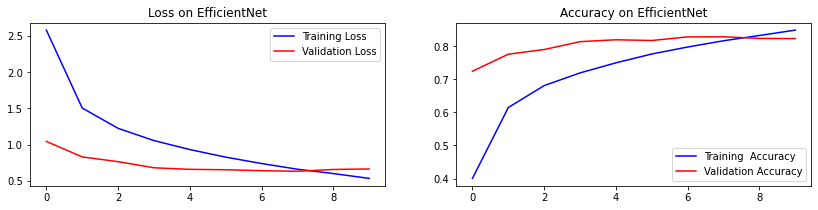

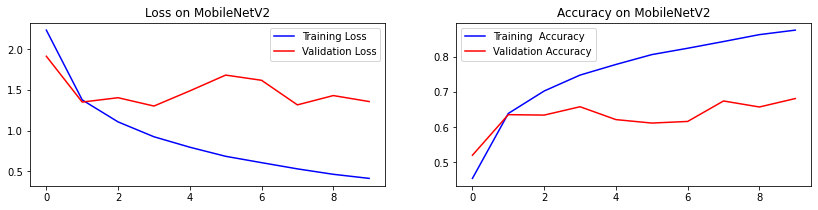

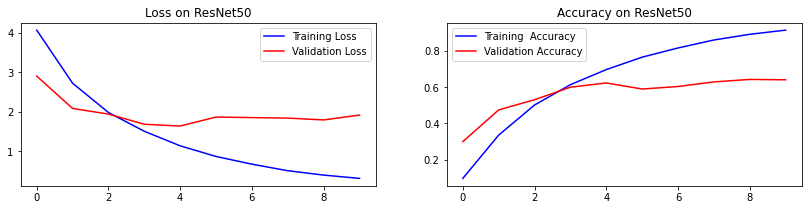

In [16]:
smd.showing_learning_history()

In [17]:
data = smd.get_result()
data.to_csv('out.csv')

In [18]:
data

,accuracy,gini,roc_auc,time_fit,time_predict
EfficientNet,0.831220,0.992673,0.996337,6504.290582,21.175311
MobileNetV2,0.684548,0.976084,0.988042,4561.488522,14.459144
ResNet50,0.638510,0.943636,0.971818,7485.472763,30.573594


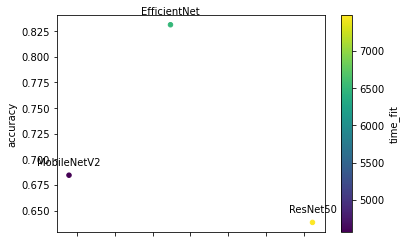

In [19]:
ax1 = data.plot.scatter(x='time_predict',
                        y='accuracy',
                        c= 'time_fit',
                        colormap='viridis'
                        )


for i in range(data.shape[0]):
    plt.annotate(data.index.to_list()[i], 
                 (data['time_predict'][i],data['accuracy'][i]), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 
plt.show()

### Итоги:



Архитектуры:
Все сети являются предобученными.
EfficientNet - считается хорошей и легкой нейронной сетью (имеет 7 блоков состоящих из 5 модулей и содержащие в сумме 237 слоя, использующее inverted bottleneck MBConv, который впервые был представлен в MobileNetV2).
MobileNetV2 - создавлся для класификации, детектирования объектов и семантической сегментации на мобильных устройствах
ResNet50 - классика жанра

Измерение точности модели:
Почему именно accuracy? Аccuracy в лобовую смотрит долю правильных ответов к общей массе, что позволяет уйти от балансов класса. 
Gini (https://en.wikipedia.org/wiki/Gini_coefficient) вариант ROC AUC с диапазоном значений от 0 до 1 (ROC AUC 0.5-1). Обычно используются для бинарной классификации. Много классовую классификацию можно представить, как бинарную классификацию (целевой класс к остальным и усреднением значений с учетом веса данного класса в выборке), но при увеличении количества классов дельта точности будет падать.

Модель: всё довольно ожидаемо. Надо понимать, что нам важнее точность или FPS.
Для выбора модели, нужно прогнать их на 100 эпохах. Сейчас видно, что FPS у ResNet50 хуже, чем у всех. Скорей всего в определенный момент MobileNetV2 упрется в предел точности из-за облегчённой архитектуры, а EfficientNet будет продолжать расти (это гипотеза).